# Create a training set of reviews with balanced ratings 

In [1]:
import numpy as np
import pandas as pd
import pickle
import gzip
import math
import random
from sklearn.model_selection import train_test_split

data_path = '../datasets/'

In [2]:
pickle_in = open(data_path + "amzn_2M_skip2M.pkl","rb")
comments_df = pickle.load(pickle_in)

# Configuration

In [3]:
NB_EACH_CLASS = 41000 # Number of Training + Test samples of each class
TEST_RATIO = 0.2 # Test set
POS_NEG = True  # Merge 1-2 stars into NEG, 4-5 stars into POS, drop 3
MIN_NB_SENTENCES = 5

## Check that balanced classes can be reached for the requested configuration

In [7]:
from src.utils import nb_sentences, not_about_support

# Disabling chained assignment warning is OK because output not modified,
# simply used for diagnostic. Runs faster without copy
pd.set_option('mode.chained_assignment', None) 

minimum = NB_EACH_CLASS + 10
all = {}
for i in range(1,6):
    all[i] = comments_df[comments_df['overall'] == i]
    all[i]['nb_sentences'] = nb_sentences(all[i]['reviewText'])
    all[i] = all[i][all[i]['nb_sentences'] >= MIN_NB_SENTENCES]
    all[i] = all[i][not_about_support(all[i]['reviewText'])]
    
    minimum = min(all[i].shape[0], minimum)
if minimum < NB_EACH_CLASS:
    print('Maximum for balanced classes is ', minimum)
else:
    print('No problem!')
    
pd.set_option('mode.chained_assignment', 'warn')

No problem!


In [8]:
from IPython.display import display
pd.set_option('display.max_colwidth', 10)

for i in range(1,6):
    display(all[i].head(3))

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,nb_sentences
453,A1U1SC...,000511...,David'...,"[41, 58]",The fi...,1.0,Accura...,123128...,"01 7, ...",37
524,AJP33G...,000511...,Justin...,"[26, 37]",Utterl...,1.0,Sexual...,127854...,"07 8, ...",12
600,A2RI2A...,000511...,sharp ...,"[13, 23]",The ac...,1.0,Nakedn...,129885...,"02 28,...",5


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,nb_sentences
8,A5Y15S...,000058...,Cather...,"[12, 16]","I, too...",2.0,C+ At ...,130740...,"06 7, ...",8
371,A34WKQ...,000504...,A Fan,"[1, 1]",Kent H...,2.0,Not a ...,131492...,"09 2, ...",6
443,APY0LS...,000511...,Critic...,"[4, 6]",This f...,2.0,"Sorry,...",127638...,"06 13,...",10


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,nb_sentences
195,A2KJO4...,000501...,Jules ...,"[0, 0]",Should...,3.0,Christ...,119914...,"01 1, ...",5
283,AA8XMU...,000501...,Pilgram,"[2, 2]",Worth ...,3.0,Made t...,138525...,"11 24,...",6
350,A2JP0U...,000501...,Tim Ja...,"[9, 13]",For so...,3.0,FONZIE...,110237...,"12 7, ...",7


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,nb_sentences
90,A3ECX7...,000501...,Cheryl...,"[2, 2]",This i...,4.0,An Ame...,116881...,"01 15,...",7
119,A2QXBB...,000501...,Dennis...,"[0, 0]",A bril...,4.0,Brilli...,120242...,"02 8, ...",5
217,A3P98J...,000501...,Ken Ro...,"[44, 46]",Henry ...,4.0,grey,100344...,"10 19,...",7


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,nb_sentences
11,ANF0AG...,000058...,Gramma...,"[13, 13]",My 18 ...,5.0,Most H...,130818...,"06 16,...",7
12,A3LDEB...,000058...,Jami H...,"[10, 11]",The be...,5.0,Why do...,120899...,"04 24,...",5
18,ASB0E2...,000058...,Kindle...,"[2, 2]",Book R...,5.0,Why Do...,132295...,"12 4, ...",39


## Create train and test sets at random, from most recent reviews

In [9]:
train_test = {'train': {}, 'test':{}}
random.seed(0) # for reproducibility
train_idx_filter = np.ones((NB_EACH_CLASS,), dtype=bool)

for i in random.sample(range(NB_EACH_CLASS), 
                                math.floor(NB_EACH_CLASS * TEST_RATIO)):
    train_idx_filter[i] = False

for i in range(1,6):
    #                          use the most recent movies
    train_test['train'][i] = all[i][-NB_EACH_CLASS:][train_idx_filter]
    train_test['test'][i] = all[i][-NB_EACH_CLASS:][~train_idx_filter]
    

In [10]:

if POS_NEG:
    train_test_pos_neg = {'train':{}, 'test':{}}
    train_test_pos_neg['train']['positive'] = pd.concat([
        train_test['train'][4],
        train_test['train'][5]
    ])
    train_test_pos_neg['train']['negative'] = pd.concat([
        train_test['train'][1],
        train_test['train'][2],
    ])
    train_test_pos_neg['test']['positive'] = pd.concat([
        train_test['test'][4],
        train_test['test'][5],
    ])    
    train_test_pos_neg['test']['negative'] = pd.concat([
        train_test['test'][1],
        train_test['test'][2]
    ]) 
else:
    train_test_merged_classes = {}
    train_test_merged_classes['train'] = pd.concat([
        train_test['train'][1],
        train_test['train'][2],
        train_test['train'][3],
        train_test['train'][4],
        train_test['train'][5]
    ])
    train_test_merged_classes['test'] = pd.concat([
        train_test['test'][1],
        train_test['test'][2],
        train_test['test'][3],
        train_test['test'][4],
        train_test['test'][5]
    ])

## Result check

In [11]:
pb = False
if POS_NEG:
    if (train_test_pos_neg['train']['positive'].shape[0] 
                        != NB_EACH_CLASS * 2 * (1-TEST_RATIO)):
        pb = True
        
else:
    if ((train_test_merged_classes['train'].shape[0] 
        + train_test_merged_classes['test'].shape[0] == NB_EACH_CLASS * 5) & 
        (train_test_merged_classes['train'].shape[0] / (1-TEST_RATIO) == NB_EACH_CLASS * 5)):
        pb = True
if pb:
    print('@@@ There was a problem during creation @@@')
else:
    print('No problems found')

No problems found


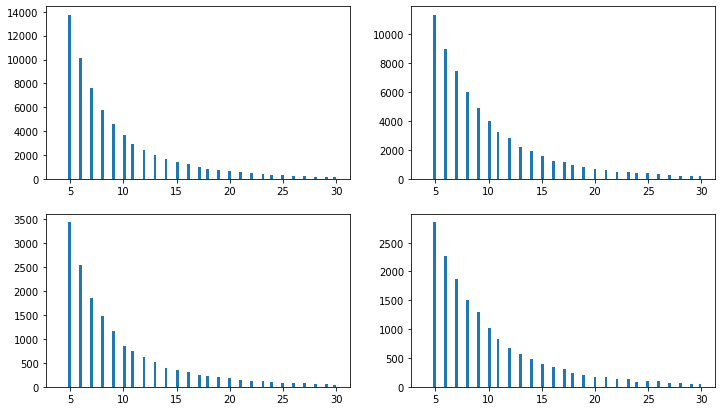

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(2,2,figsize=(12,7))
for i, tt in enumerate(['train', 'test']):
    for j, pn in enumerate(['positive', 'negative']):
        axs[i][j].hist(train_test_pos_neg[tt][pn]['nb_sentences'],bins=100, range=(4,30));

## Save the balanced training set

In [13]:
if POS_NEG:
    samples_nb = str(NB_EACH_CLASS * 4)
    pickle_out = open(data_path + samples_nb + "_balanced_pos_neg_train_test_reviews_5_no_support.pkl","wb")
    pickle.dump(train_test_pos_neg, pickle_out)    
else:
    samples_nb = str(NB_EACH_CLASS * 5)
    pickle_out = open(data_path + samples_nb + "_balanced_train_test_reviews.pkl","wb")
    pickle.dump(train_test_merged_classes, pickle_out)

pickle_out.close()

In [14]:
train_test_pos_neg['train']['positive'].head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,nb_sentences
1384368,A1YQ6Q...,B00005...,David ...,"[1, 3]",&quot;...,4.0,Blonde...,106945...,"11 22,...",15
1384394,A3OPUU...,B00005...,Fuchs ...,"[2, 2]",It sta...,4.0,Shock!,106021...,"08 7, ...",5
